In [29]:
import os
from glob import glob

ct_path = '/share/sda/mohammadqazi/project/hector/pre_processed'
ct = sorted(glob(os.path.join(ct_path, "*ct_roi*.npz")))

mask_path = '/share/sda/mohammadqazi/project/hector/dataset/processed_samples_all'
mask = sorted(glob(os.path.join(mask_path, "*mask_roi*.nii.gz")))

In [30]:
from torch.utils.data import Dataset

class Hector_Dataset_segmentation_emb(Dataset):
    def __init__(self, ct_path, mask_path, csv_file):

        self.ct = sorted(glob(os.path.join(ct_path, "*ct_roi*.npz")))
        self.mask = sorted(glob(os.path.join(mask_path, "*mask_roi*.nii.gz")))
        self.dataframe = pd.read_csv(csv_file)
    
    def prepare_samples(self):
        samples = []
        
        for index, row in tqdm(self.dataframe.iterrows()):
            filename = row['PatientID'] + "_ct_roi.npz"
            filepath_ct = os.path.join(self.data_folder, filename)
            hidden_state = self.emd[filename]['hidden_state']
            fold = row['fold']
            filepath_mask = os.path.join('/share/sda/mohammadqazi/project/hector/dataset/processed_samples_all/', (row['PatientID'] + "_mask_roi.nii.gz"))
            samples.append((hidden_state, filepath_ct, filepath_mask, fold))

        return samples

    def __len__(self):
        return len(self.ct)

    def __getitem__(self, idx):
        ct = np.load(self.ct[idx])['arr_0']
        mask = nib.load(self.mask[idx]).get_fdata()
        return ct, mask

(524, 524)

In [16]:
import os
from glob import glob
import numpy as np
import nibabel as nib
from monai.transforms import (
    Compose,
    LoadImaged,
    MapTransform,
    SpatialPadd,
    Orientationd,
    NormalizeIntensityd,
    RandFlipd,
    RandRotate90d,
    ConcatItemsd,
    Resized
)
from monai.data import Dataset

# Custom transform to load NPZ files.
class LoadNPZd(MapTransform):
    """
    Dictionary-based transform to load a NPZ file.
    Expects the NPZ file to have an array stored under the key 'arr_0'
    and then adds a channel dimension.
    """
    def __init__(self, keys):
        super().__init__(keys)
        
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            file_path = d[key]
            # load NPZ file and extract the array (assuming 'arr_0')
            npz_data = np.load(file_path)['arr_0']
            # Add a channel dimension (to be consistent with MONAI)
            npz_data = np.expand_dims(npz_data, axis=0)
            npz_data = npz_data.transpose(0, 2, 3, 1)
            d[key] = npz_data
        return d

# Define your paths:
ct_path = '/share/sda/mohammadqazi/project/hector/pre_processed'
mask_path = '/share/sda/mohammadqazi/project/hector/dataset/processed_samples_all'

# Sort the files according to your naming conventions.
ct_files = sorted(glob(os.path.join(ct_path, "*ct_roi*.npz")))
mask_files = sorted(glob(os.path.join(mask_path, "*mask_roi*.nii.gz")))

# Check that the number of CT files matches the number of mask files.
print(f"Found {len(ct_files)} CT files and {len(mask_files)} mask files.")

# Create a list of dictionaries, each containing the paths for the CT and the segmentation mask.
data_files = [{"ct": ct_file, "seg": mask_file} for ct_file, mask_file in zip(ct_files, mask_files)]

# Define a training transform pipeline.
train_transforms = Compose(
    [
        # Load the CT NPZ using our custom loader and the mask using MONAI's loader.
        LoadNPZd(keys=["ct"]),
        LoadImaged(keys=["seg"], ensure_channel_first=True),
        # Optionally pad to a fixed spatial size.
        SpatialPadd(keys=["ct", "seg"], spatial_size=(96, 96, 96), method="end"),
        # Optionally reorient (if needed).
        Orientationd(keys=["ct", "seg"], axcodes="RAS"),
        # Normalize the intensity of the CT.
        NormalizeIntensityd(keys=["ct"], channel_wise=True),
        # You can also concatenate items if you need multi-channel inputs (here we have only one CT image).
        # ConcatItemsd(keys=["ct"], name="image"),
        # Data augmentation: random flips and rotations.
        Resized(keys=["ct", "seg"], spatial_size=(96, 96, 96)),
        # RandCropByPosNegLabeld(
        #     keys=["ct", "seg"],
        #     label_key="seg",
        #     spatial_size=(96, 96, 96),
        #     pos=1,
        #     neg=1,
        #     num_samples=num_samples,
        #     image_key="ctpt",
        #     image_threshold=0,
        # ),
        RandFlipd(keys=["ct", "seg"], spatial_axis=0, prob=0.5),
        RandFlipd(keys=["ct", "seg"], spatial_axis=1, prob=0.5),
        RandFlipd(keys=["ct", "seg"], spatial_axis=2, prob=0.5),
        RandRotate90d(keys=["ct", "seg"], prob=0.5, max_k=3),
    ]
)

# Create MONAI Dataset for training.
train_ds = Dataset(data=data_files, transform=train_transforms)

# For demonstration, load one sample and visualize its shapes.
sample = train_ds[0]
print("CT shape:", sample["ct"].shape)
print("Seg shape:", sample["seg"].shape)


Found 524 CT files and 524 mask files.
CT shape: torch.Size([1, 96, 96, 96])
Seg shape: torch.Size([1, 96, 96, 96])


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming you've prepared a list of file dictionaries, e.g.:
# data_files = [{"hidden_state": hidden_state, "ct": filepath_ct, "seg": filepath_mask, "fold": fold}, ...]

# Extract the dictionaries that belong to a given fold for validation:
val_files = [d for d in data_files if d["fold"] == fold]
train_files = [d for d in data_files if d["fold"] != fold]

# Now create MONAI Datasets:
from monai.data import Dataset
train_ds = Dataset(data=train_files, transform=train_transforms)
val_ds = Dataset(data=val_files, transform=val_transforms)


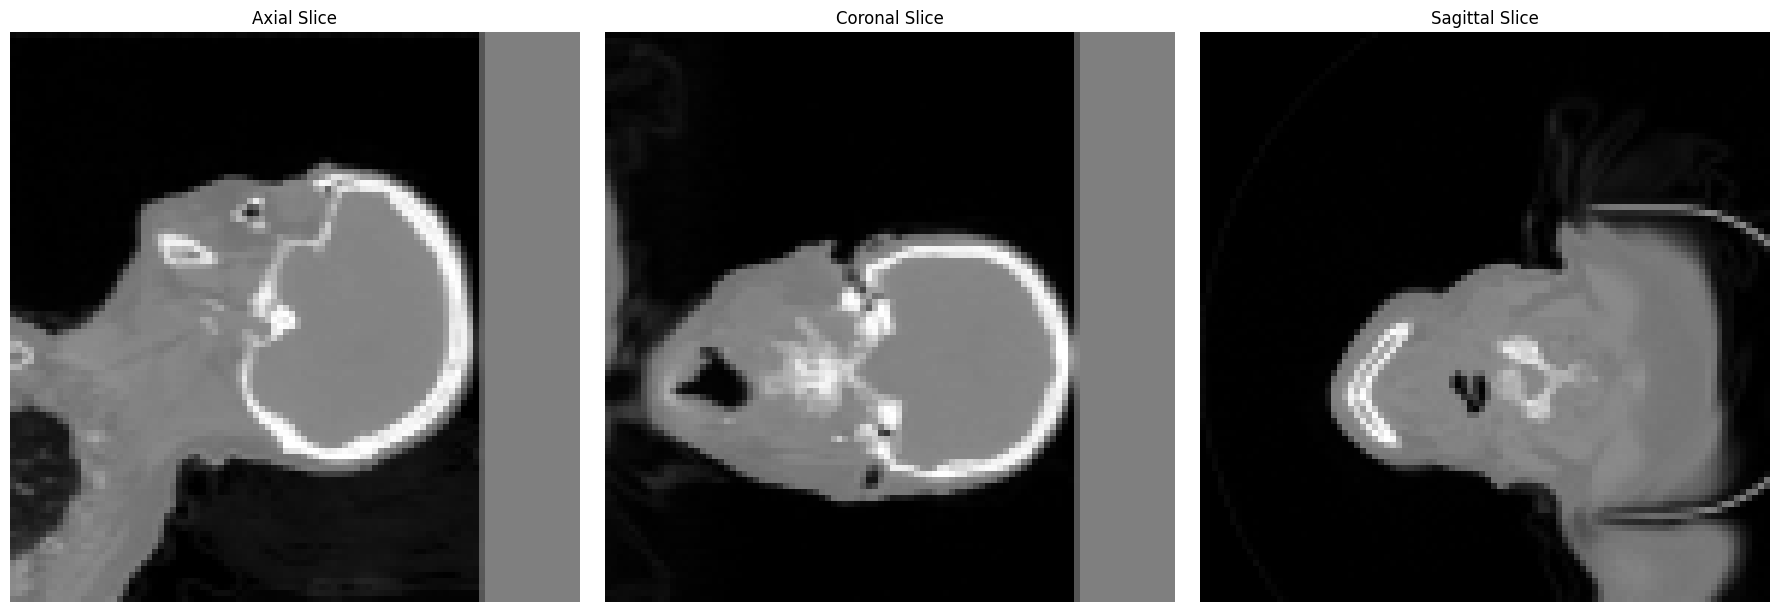

In [21]:
import numpy as np
import matplotlib.pyplot as plt

ct_scan = sample["ct"].squeeze(0)

# Assume 'ct_scan' is your 3D CT volume with shape (240, 480, 480)
# For example, you could load it from a NIfTI file using nibabel:
# import nibabel as nib
# ct_scan = nib.load('path_to_ct_scan.nii.gz').get_fdata()

# Calculate mid-slices for each axis
mid_slice_axial   = ct_scan[ct_scan.shape[0] // 2, :, :]   # axial view (slice along first dimension)
mid_slice_coronal = ct_scan[:, ct_scan.shape[1] // 2, :]   # coronal view (slice along second dimension)
mid_slice_sagittal= ct_scan[:, :, ct_scan.shape[2] // 4]   # sagittal view (slice along third dimension)

# Plot each slice using matplotlib
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Axial view
axes[0].imshow(mid_slice_axial, cmap='gray')
axes[0].set_title('Axial Slice')
axes[0].axis('off')

# Coronal view
axes[1].imshow(mid_slice_coronal, cmap='gray')
axes[1].set_title('Coronal Slice')
axes[1].axis('off')

# Sagittal view
axes[2].imshow(mid_slice_sagittal, cmap='gray')
axes[2].set_title('Sagittal Slice')
axes[2].axis('off')

plt.tight_layout()
plt.show()


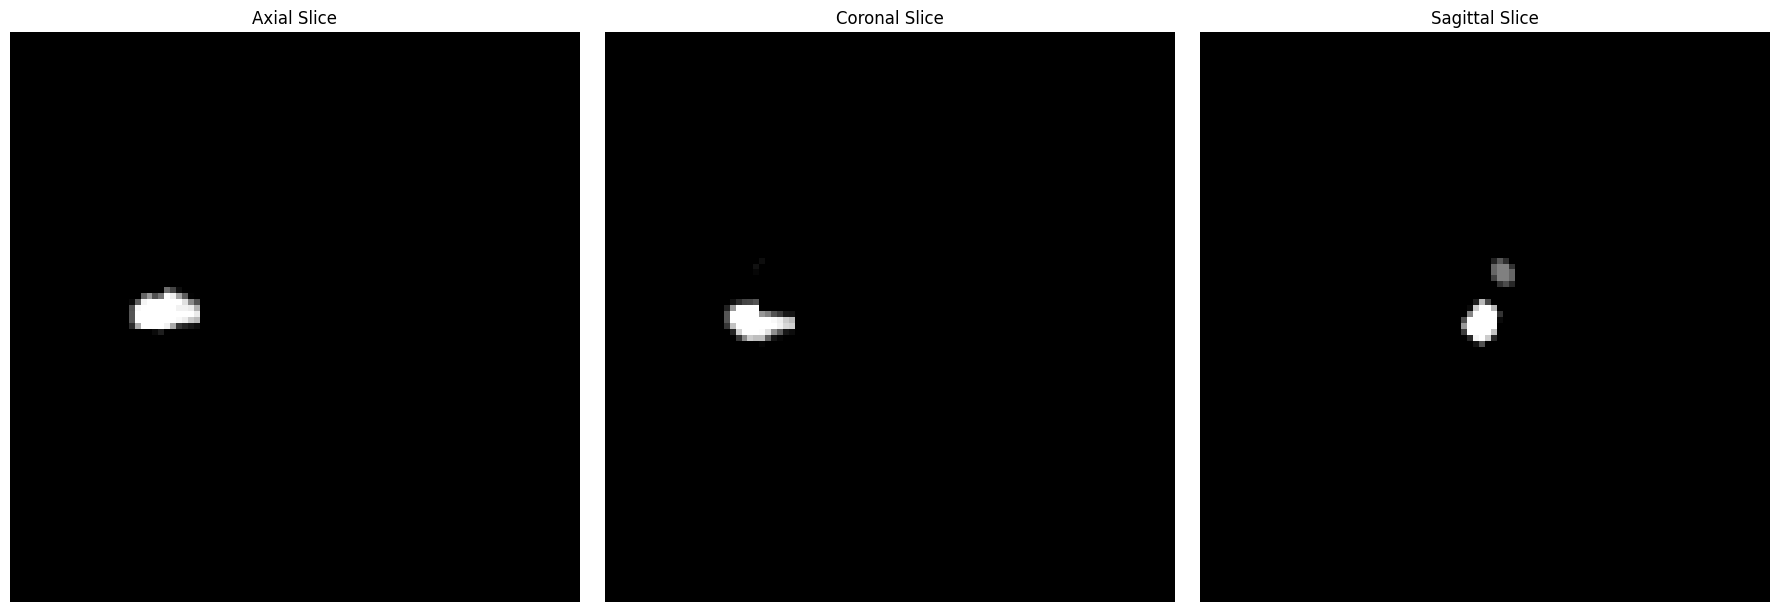

In [20]:
import numpy as np
import matplotlib.pyplot as plt

ct_scan = sample["seg"].squeeze(0)

# Assume 'ct_scan' is your 3D CT volume with shape (240, 480, 480)
# For example, you could load it from a NIfTI file using nibabel:
# import nibabel as nib
# ct_scan = nib.load('path_to_ct_scan.nii.gz').get_fdata()

# Calculate mid-slices for each axis
mid_slice_axial   = ct_scan[ct_scan.shape[0] // 2, :, :]   # axial view (slice along first dimension)
mid_slice_coronal = ct_scan[:, ct_scan.shape[1] // 2, :]   # coronal view (slice along second dimension)
mid_slice_sagittal= ct_scan[:, :, ct_scan.shape[2] // 4]   # sagittal view (slice along third dimension)

# Plot each slice using matplotlib
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Axial view
axes[0].imshow(mid_slice_axial, cmap='gray')
axes[0].set_title('Axial Slice')
axes[0].axis('off')

# Coronal view
axes[1].imshow(mid_slice_coronal, cmap='gray')
axes[1].set_title('Coronal Slice')
axes[1].axis('off')

# Sagittal view
axes[2].imshow(mid_slice_sagittal, cmap='gray')
axes[2].set_title('Sagittal Slice')
axes[2].axis('off')

plt.tight_layout()
plt.show()


In [1]:
import os
import numpy as np
import pandas as pd
from monai.data import Dataset
from tqdm import tqdm
from monai.transforms import (
    Compose,
    LoadImaged,
    MapTransform,
    SpatialPadd,
    Orientationd,
    NormalizeIntensityd,
    RandFlipd,
    RandRotate90d,
    Resized,
    ScaleIntensityRangeD,
)

# Custom transform to load NPZ files.
class LoadNPZd(MapTransform):
    """
    Dictionary-based transform to load an NPZ file.
    Expects the NPZ file to have an array stored under 'arr_0'
    and then adds a channel dimension.
    """
    def __init__(self, keys):
        super().__init__(keys)

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            file_path = d[key]
            npz_data = np.load(file_path)['arr_0']
            # If npz_data is 3D, add a channel dimension to become (1, D, H, W)
            # if npz_data.ndim == 3:
            npz_data = np.expand_dims(npz_data, axis=0)
            # npz_data = npz_data.transpose(0, 2, 3, 1)
            d[key] = npz_data
        return d

# Custom transform to keep 'hidden_state' unchanged
class IdentityTransform(MapTransform):
    """
    A MONAI transform that simply passes through the hidden state
    without modification.
    """
    def __call__(self, data):
        return data  # No modifications

class HectorMONAIDataset:
    """
    A helper class that reads a CSV to build samples and returns MONAI Dataset objects.
    The dataset includes:
      - "ct": CT scan in NPZ format
      - "seg": Corresponding segmentation in NIfTI format
      - "hidden_state": Precomputed embeddings stored in an NPZ file
    """
    def __init__(self, data_folder, emd_path, csv_file, seg_folder):
        """
        Parameters:
            data_folder (str): Path to folder containing CT NPZ files.
            emd_path (str): Path to NPZ file containing the embeddings (should be a dictionary).
            csv_file (str): CSV file with at least 'PatientID' and 'fold' columns.
            seg_folder (str): Folder path where the segmentation NIfTI files are stored.
        """
        self.data_folder = data_folder
        self.seg_folder = seg_folder
        self.emd = np.load(emd_path, allow_pickle=True).item()
        self.dataframe = pd.read_csv(csv_file)[:5]
        self.samples = self.prepare_samples()

    def prepare_samples(self):
        samples = []
        # Iterate over each row in the CSV.
        for idx, row in tqdm(self.dataframe.iterrows()):
            patient_id = row['PatientID']
            # Build filepaths based on the patient ID.
            # ct_filename = patient_id + "_ct_roi.npz"
            ct_filename = patient_id + "_ct_roi.nii.gz"
            ct_filepath = os.path.join(self.data_folder, ct_filename)
            seg_filename = patient_id + "_mask_roi.nii.gz"
            seg_filepath = os.path.join(self.seg_folder, seg_filename)
            # Retrieve the hidden state from the embedding dictionary.
            hidden_state = self.emd[patient_id + "_ct_roi.npz"]['hidden_state']
            fold = row['fold']
            # Build a dictionary sample.
            sample = {
                "hidden_state": hidden_state,  # Will be preserved
                "ct": ct_filepath,
                "seg": seg_filepath,
                "fold": fold,
            }
            samples.append(sample)
        return samples

    def train_val_split(self, fold, train_transforms: Compose, val_transforms: Compose):
        """
        Splits the samples based on the provided fold value and returns MONAI Datasets.
        
        Parameters:
            fold (int or str): The fold value that defines the validation samples.
            train_transforms (Compose): MONAI Compose transform for training.
            val_transforms (Compose): MONAI Compose transform for validation.
            
        Returns:
            train_ds (monai.data.Dataset): Training dataset.
            val_ds (monai.data.Dataset): Validation dataset.
        """
        train_samples = [s for s in self.samples if s["fold"] != fold]
        val_samples = [s for s in self.samples if s["fold"] == fold]
        train_ds = Dataset(data=train_samples, transform=train_transforms)
        val_ds = Dataset(data=val_samples, transform=val_transforms)
        return train_ds, val_ds

# Example usage:

# Define your folder paths.
# ct_path = '/share/sda/mohammadqazi/project/hector/pre_processed'
ct_path =  '/share/sda/mohammadqazi/project/hector/dataset/processed_samples_all'
seg_folder = '/share/sda/mohammadqazi/project/hector/dataset/processed_samples_all'
emd_path = '/share/sda/mohammadqazi/project/CTscan_prognosis_VLM-main/docs/embeddings/seg.npy'
csv_file = '/share/sda/mohammadqazi/project/CTscan_prognosis_VLM-main/docs/TNM_hector_prompts.csv'

# Define MONAI transforms.
# For the CT, we use our custom NPZ loader; for segmentation, we use MONAI's LoadImaged.
train_transforms = Compose([
    # LoadNPZd(keys=["ct"]),
    LoadImaged(keys=["ct", "seg"], ensure_channel_first=True),
    IdentityTransform(keys=["hidden_state"]),  # Preserve hidden state
    ScaleIntensityRangeD(
        keys=["ct"],
        a_min=-1024,  # Clamp minimum value
        a_max=1024,  # Clamp maximum value
        b_min=-1,    # Normalize to range [-1, 1]
        b_max=1,
        clip=True    # Ensure values stay within the specified range
    ),
    Orientationd(keys=["ct", "seg"], axcodes="RAS"),
    NormalizeIntensityd(keys=["ct"], channel_wise=True),
    # Resized(keys=["ct", "seg"], spatial_size=(96, 96, 96)),
    RandFlipd(keys=["ct", "seg"], spatial_axis=0, prob=0.5),
    RandFlipd(keys=["ct", "seg"], spatial_axis=1, prob=0.5),
    RandFlipd(keys=["ct", "seg"], spatial_axis=2, prob=0.5),
    RandRotate90d(keys=["ct", "seg"], prob=0.5, max_k=3),
])

val_transforms = Compose([
    # LoadNPZd(keys=["ct"]),
    LoadImaged(keys=["ct", "seg"], ensure_channel_first=True),
    IdentityTransform(keys=["hidden_state"]),  # Preserve hidden state
    ScaleIntensityRangeD(
        keys=["ct"],
        a_min=-1024,  # Clamp minimum value
        a_max=1024,  # Clamp maximum value
        b_min=-1,    # Normalize to range [-1, 1]
        b_max=1,
        clip=True    # Ensure values stay within the specified range
    ),
    # Resized(keys=["ct", "seg"], spatial_size=(96, 96, 96)),
    Orientationd(keys=["ct", "seg"], axcodes="RAS"),
    NormalizeIntensityd(keys=["ct"], channel_wise=True),
])

# Create an instance of the dataset class.
hector_data = HectorMONAIDataset(data_folder=ct_path, emd_path=emd_path, csv_file=csv_file, seg_folder=seg_folder)

# For example, use fold 0 for validation.
train_ds, val_ds = hector_data.train_val_split(fold=0, train_transforms=train_transforms, val_transforms=val_transforms)

# Create DataLoaders.
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4)

# Fetch a sample batch
sample_batch = next(iter(train_loader))

# Check if hidden_state is present
print(sample_batch.keys())  # Should contain 'ct', 'seg', and 'hidden_state'
print(sample_batch["hidden_state"].shape)  # Should match the shape of the embeddings

5it [00:00, 1646.76it/s]


dict_keys(['hidden_state', 'ct', 'seg', 'fold'])
torch.Size([2, 4, 512, 24, 24, 24])


In [1]:
sample_batch['ct'][0].shape, sample_batch['seg'][0].shape

NameError: name 'sample_batch' is not defined

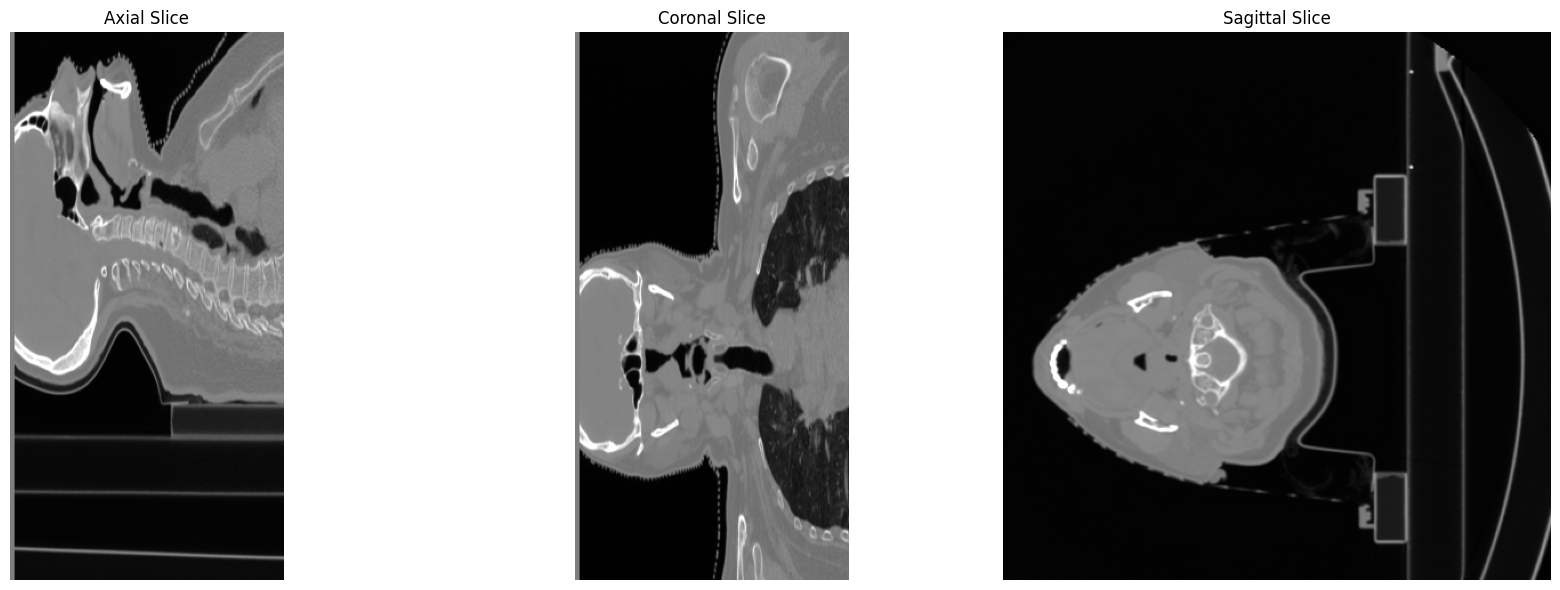

In [39]:
import numpy as np
import matplotlib.pyplot as plt

ct_scan = sample_batch["ct"][0].squeeze(0)

# Assume 'ct_scan' is your 3D CT volume with shape (240, 480, 480)
# For example, you could load it from a NIfTI file using nibabel:
# import nibabel as nib
# ct_scan = nib.load('path_to_ct_scan.nii.gz').get_fdata()

# Calculate mid-slices for each axis
mid_slice_axial   = ct_scan[ct_scan.shape[0] // 2, :, :]   # axial view (slice along first dimension)
mid_slice_coronal = ct_scan[:, ct_scan.shape[1] // 2, :]   # coronal view (slice along second dimension)
mid_slice_sagittal= ct_scan[:, :, ct_scan.shape[2] // 2]   # sagittal view (slice along third dimension)

# Plot each slice using matplotlib
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Axial view
axes[0].imshow(mid_slice_axial, cmap='gray')
axes[0].set_title('Axial Slice')
axes[0].axis('off')

# Coronal view
axes[1].imshow(mid_slice_coronal, cmap='gray')
axes[1].set_title('Coronal Slice')
axes[1].axis('off')

# Sagittal view
axes[2].imshow(mid_slice_sagittal, cmap='gray')
axes[2].set_title('Sagittal Slice')
axes[2].axis('off')

plt.tight_layout()
plt.show()


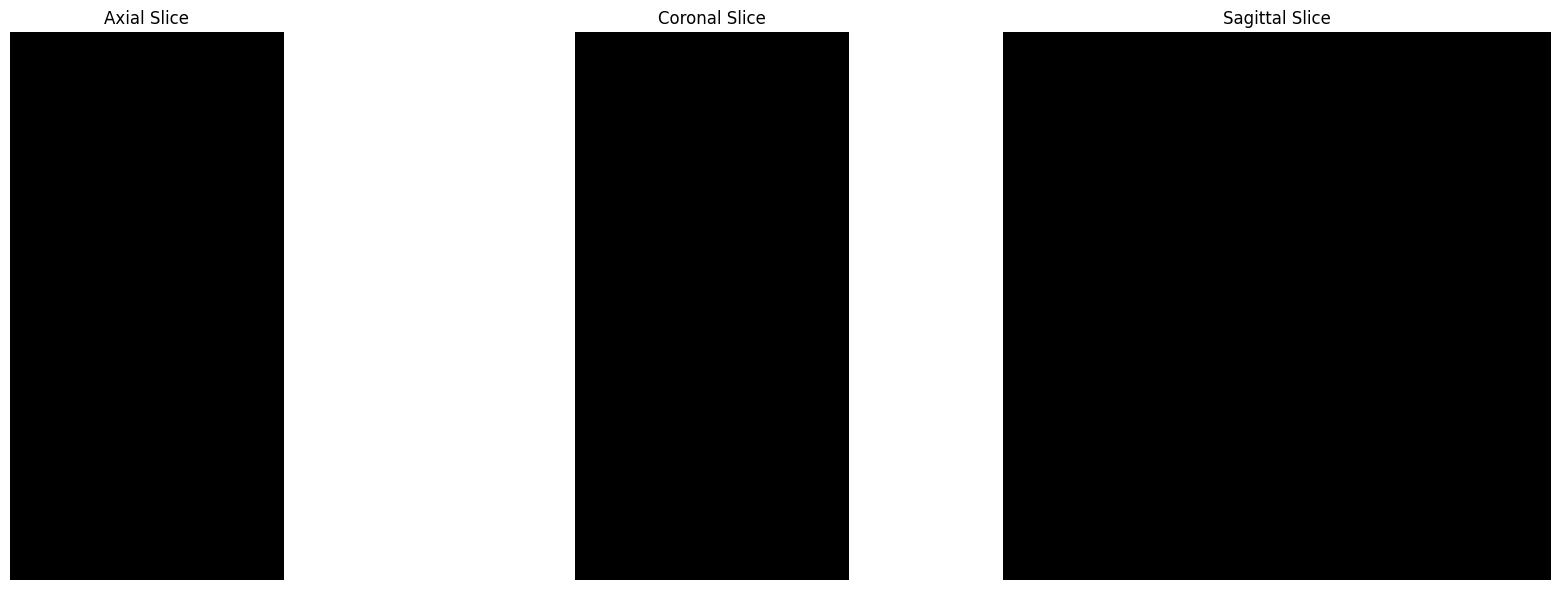

In [41]:
import numpy as np
import matplotlib.pyplot as plt

ct_scan = sample_batch["seg"][0].squeeze(0)

# ct_scan.shape[2] // 2

# Calculate mid-slices for each axis
mid_slice_axial   = ct_scan[ct_scan.shape[0] // 2, :, :]   # axial view (slice along first dimension)
mid_slice_coronal = ct_scan[:, ct_scan.shape[1] // 2, :]   # coronal view (slice along second dimension)
mid_slice_sagittal= ct_scan[:, :, ct_scan.shape[2] // 2]   # sagittal view (slice along third dimension)

# Plot each slice using matplotlib
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Axial view
axes[0].imshow(mid_slice_axial, cmap='gray')
axes[0].set_title('Axial Slice')
axes[0].axis('off')

# Coronal view
axes[1].imshow(mid_slice_coronal, cmap='gray')
axes[1].set_title('Coronal Slice')
axes[1].axis('off')

# Sagittal view
axes[2].imshow(mid_slice_sagittal, cmap='gray')
axes[2].set_title('Sagittal Slice')
axes[2].axis('off')

plt.tight_layout()
plt.show()
